In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from sklearn.preprocessing import StandardScaler

2023-02-14 23:18:11.810435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('data/df_parsed_lin.csv')

df['time'] = pd.to_datetime(df['time'])

#drop index column
df = df.drop('Unnamed: 0', axis = 1)
df.head()

,time,BG2,BX2,BQ7,BX1,BT4,BT6,BT5,BL0,CD1,...,TH4,TH2,WA8,WA2,MY1,WM6,NB1,MW4,MW2,MW1
0,2017-01-01,13.4,20.3,8.000000,8.7,60.8,37.8,28.0,24.5,48.2,...,40.2,41.4,63.2,25.2,60.4,56.7,62.5,9.8,19.0,27.9
1,2017-01-02,32.4,44.8,23.700000,20.0,79.1,47.8,41.4,34.5,61.0,...,61.3,57.3,77.6,51.4,50.2,55.3,53.8,19.8,32.4,32.6
2,2017-01-03,50.3,60.1,48.400000,29.8,96.5,73.3,80.5,46.9,61.0,...,71.5,72.7,105.1,43.7,107.6,92.7,98.0,31.8,41.8,56.0
3,2017-01-04,42.1,51.5,42.692857,24.7,72.5,61.9,69.8,45.8,77.3,...,73.7,73.1,100.9,43.5,74.0,82.2,78.8,22.8,41.7,43.6
4,2017-01-05,60.6,83.8,68.000000,48.6,136.0,105.3,122.1,59.6,107.8,...,112.6,99.3,155.7,62.8,93.5,95.6,116.6,58.5,90.4,81.6


In [3]:
#add columns for highlighting weekly periodicity
days_in_week = 7
df['week sin'] = np.sin(df['time'].dt.dayofweek * 2*np.pi/days_in_week)
df['week cos'] = np.cos(df['time'].dt.dayofweek * 2*np.pi/days_in_week)

#add binary variable to encode whether or not it's a weekday. 
#make it easier for model to understand that weekends are special
df['weekday'] = df['time'].dt.dayofweek < 5 #saturday and sunday are 5 and 6, respectively.

#add column highlighting yearly periodicity (remember that leap years are a thing.)
days_in_year = 365.2425
df['year sin'] = np.sin(df['time'].dt.dayofyear * 2*np.pi/days_in_year)
df['year cos'] = np.cos(df['time'].dt.dayofyear * 2*np.pi/days_in_year)

#add column marking days since beginning of dataset (helps network learn overall trend rather than seasonality)
seconds_in_day = 60*60*24
df['day'] = df['time'].view(int)/1e9 /seconds_in_day #days since beginning of UNIX (to be scaled/normalized)

#in the future, add a column highlighting whether it's a holiday
#also try adding weather variables.
#also try adding income variables

In [4]:
"""
Split data into training, validation, and test sets. 
Training will be from 2017-2019. (50% of data)
Validation will be 2019-2020. (25% of data)
Test will be from 2020 to 2021. (25% of data)
"""

t1 = datetime.datetime.strptime('2019/01/01','%Y/%m/%d')
t2 = datetime.datetime.strptime('2020/01/01','%Y/%m/%d')


train_df = df[df['time'] < t1]
val_df = df[(df['time'] >= t1) & (df['time'] < t2)]
test_df = df[df['time'] >= t2]

#drop datetime column from features
train_df = train_df.drop('time', axis = 1)
val_df   = val_df.drop('time', axis = 1)
test_df  = test_df.drop('time', axis = 1)

column_indices = {name: i for i, name in enumerate(df.columns)}

num_features = df.shape[1]



Now, let's scale and normalize each of the columns.

In [5]:
# scaler = StandardScaler()
# scaler.fit(train_df)

# train_df_scaled = scaler.transform(train_df)
# val_df_scaled = scaler.transform(val_df)
# test_df_scaled = scaler.transform(test_df)

train_mean, train_std = train_df.mean(), train_df.std()

train_df_scaled = (train_df - train_mean) / train_std
val_df_scaled = (val_df - train_mean) / train_std
test_df_scaled = (test_df - train_mean) / train_std

In [6]:
train_df_scaled

,BG2,BX2,BQ7,BX1,BT4,BT6,BT5,BL0,CD1,CT4,...,NB1,MW4,MW2,MW1,week sin,week cos,weekday,year sin,year cos,day
0,-1.086832,-0.505404,-1.104800,-1.319494,-0.375661,-0.245552,-0.781460,-0.945113,-0.291036,-0.857378,...,-0.886282,-0.808336,-1.047796,-0.716194,-1.103995,0.877538,-1.577786,0.024309,1.414445,-1.728495
1,0.445280,1.140258,0.200885,-0.340355,0.489982,0.372902,-0.031545,-0.181202,0.381367,-0.848879,...,-1.229076,0.195539,-0.157857,-0.366558,0.001514,1.409358,0.632931,0.048604,1.413817,-1.723753
2,1.888691,2.167957,2.255051,0.508810,1.313052,1.949961,2.156639,0.766048,0.381367,0.239012,...,0.512475,1.400189,0.466428,1.374178,1.107024,0.877538,0.632931,0.072885,1.412772,-1.719010
3,1.227464,1.590296,1.780419,0.066898,0.177783,1.244923,1.557826,0.682017,1.237631,0.294256,...,-0.244036,0.496701,0.459787,0.451737,1.380062,-0.317452,0.632931,0.097144,1.411309,-1.714268
4,2.719257,3.759883,3.885078,2.137821,3.181516,3.929014,4.484732,1.736215,2.839842,0.914694,...,1.245345,4.080534,3.694118,3.278574,0.615026,-1.275759,0.632931,0.121375,1.409428,-1.709526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,1.179081,1.523126,1.722798,2.111826,1.402928,2.215896,1.048556,2.301509,1.410985,0.277258,...,0.693722,0.717554,-0.124650,0.258321,0.615026,-1.275759,0.632931,-0.103011,1.410891,1.709526
726,1.429057,1.395504,2.321583,2.172481,0.414297,1.170708,0.544882,1.354259,0.239532,0.030782,...,0.098758,1.018716,0.147644,0.340151,-0.611997,-1.275759,0.632931,-0.078758,1.412455,1.714268
727,0.429152,-0.156120,0.583442,0.205537,-0.290516,0.063675,-0.412099,0.216032,-0.790085,-0.814883,...,-0.472565,-0.216050,-1.419711,-0.567413,-1.377033,-0.317452,-1.577786,-0.054481,1.413602,1.719010
728,0.042092,-0.169554,0.625025,0.196872,-0.730433,-0.202260,-0.445677,0.361175,-1.052743,-0.946619,...,-0.669573,-0.276282,0.345517,-0.582291,-1.103995,0.877538,-1.577786,-0.030189,1.414331,1.723753


Let's create the data for training our forecasting model using data windows.

In [7]:
"""
Code from https://www.tensorflow.org/tutorials/structured_data/time_series
"""

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result
    
# WindowGenerator.split_window = split_window
# WindowGenerator.make_dataset = make_dataset
# WindowGenerator.train = train
# WindowGenerator.val = val
# WindowGenerator.test = test
# WindowGenerator.example = example


In [8]:
label_columns = list(train_df.columns[:-6])
num_outputs = len(label_columns)

#use the past week's air quality as input
num_days_input = 30

#forecast one day into the future, and only that day
shift = 1
label_width = 1

w1 = WindowGenerator(input_width=num_days_input, label_width=label_width, shift=shift, 
                     train_df = train_df_scaled, 
                     val_df = val_df_scaled, 
                     test_df = test_df_scaled,
                     label_columns=label_columns)
w1

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['BG2', 'BX2', 'BQ7', 'BX1', 'BT4', 'BT6', 'BT5', 'BL0', 'CD1', 'CT4', 'CT3', 'CR5', 'CR7', 'ZR2', 'EA6', 'EA8', 'EN5', 'EN1', 'EN4', 'EN7', 'GN0', 'GR7', 'GR4', 'GB6', 'GN4', 'GN3', 'GR9', 'GR8', 'HK6', 'HG4', 'HG1', 'HV1', 'HV3', 'LH0', 'HI0', 'IS6', 'IS2', 'KC1', 'KT4', 'LB5', 'LB6', 'LW4', 'LW2', 'NM2', 'NM3', 'RB4', 'RB7', 'RG1', 'RG6', 'RG3', 'RI2', 'RI1', 'ZV2', 'SK6', 'ST5', 'ST4', 'ST6', 'TK1', 'TK8', 'TK3', 'TH4', 'TH2', 'WA8', 'WA2', 'MY1', 'WM6', 'NB1', 'MW4', 'MW2', 'MW1']

In [9]:
# Stack three slices, the length of the total window.
#first array is the first 8 columns of train_df_scaled 
#(8 = 7 (the inputs to our model) + 1 (the day we are forecasting))
#this first array has shape 8x76. 76 = 70 (70 sites) + 6 (the extra seasonality features)
#second array is the 8 columns of train_df_scaled starting from the 100th row (also has shape 8x6)
#third array is the 8 columns of train_df_scaled starting from the 200th row
#stacking these 3 arrays gives an array with shape 3 x 8 x 76

example_window = tf.stack([np.array(train_df_scaled[:w1.total_window_size]),
                           np.array(train_df_scaled[100:100+w1.total_window_size]),
                           np.array(train_df_scaled[200:200+w1.total_window_size])])

#shape of example 

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}') #70 features since we only care about forecasting the sites.

All shapes are: (batch, time, features)
Window shape: (3, 31, 76)
Inputs shape: (3, 30, 76)
Labels shape: (3, 1, 70)


2023-02-14 23:19:03.899258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 23:19:04.201749: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 76)
Labels shape (batch, time, features): (32, 1, 70)


In [11]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [12]:
class Baseline(tf.keras.Model):
    def __init__(self):
        super().__init__()

    def call(self, inputs):
        return inputs[:,-1,:-6] #repeat outputs of last time step, throwing away the last 6 (seasonal) features

baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(w1.val)

11/11 [==============================] - 1s 3ms/step - loss: 1.8521 - mean_absolute_error: 1.0470


Epoch 1/20
22/22 [==============================] - 2s 50ms/step - loss: 2.6883 - mean_absolute_error: 0.9391 - val_loss: 2.3530 - val_mean_absolute_error: 0.8623
Epoch 2/20
22/22 [==============================] - 1s 40ms/step - loss: 1.9134 - mean_absolute_error: 0.7203 - val_loss: 2.0366 - val_mean_absolute_error: 0.8039
Epoch 3/20
22/22 [==============================] - 1s 33ms/step - loss: 1.5743 - mean_absolute_error: 0.6352 - val_loss: 1.7673 - val_mean_absolute_error: 0.7520
Epoch 4/20
22/22 [==============================] - 1s 36ms/step - loss: 1.3413 - mean_absolute_error: 0.5875 - val_loss: 1.6101 - val_mean_absolute_error: 0.7416
Epoch 5/20
22/22 [==============================] - 1s 36ms/step - loss: 1.1711 - mean_absolute_error: 0.5598 - val_loss: 1.4847 - val_mean_absolute_error: 0.7409
Epoch 6/20
22/22 [==============================] - 1s 36ms/step - loss: 1.0287 - mean_absolute_error: 0.5393 - val_loss: 1.3750 - val_mean_absolute_error: 0.7360
Epoch 7/20
22/22 [====

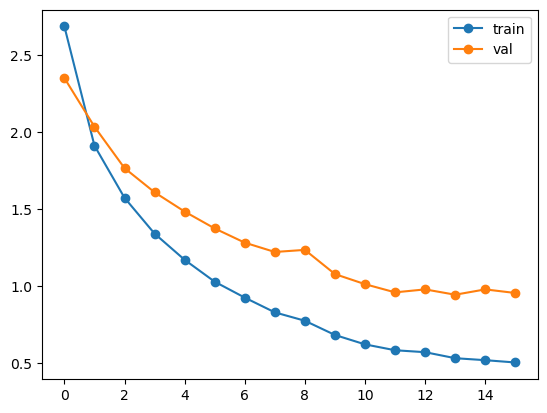

In [13]:
linear_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = num_outputs, kernel_regularizer = 'l2'),
    tf.keras.layers.Reshape((1,-1))
])

history = compile_and_fit(linear_model, w1)

val_performance['Linear'] = linear_model.evaluate(w1.val)

plt.plot(history.history['loss'],'o-',label = 'train')
plt.plot(history.history['val_loss'],'o-', label = 'val')
plt.legend()

Epoch 1/20
22/22 [==============================] - 2s 48ms/step - loss: 3.5481 - mean_absolute_error: 0.9063 - val_loss: 3.1360 - val_mean_absolute_error: 0.8364
Epoch 2/20
22/22 [==============================] - 1s 43ms/step - loss: 2.5588 - mean_absolute_error: 0.6857 - val_loss: 2.5529 - val_mean_absolute_error: 0.7756
Epoch 3/20
22/22 [==============================] - 1s 43ms/step - loss: 2.0077 - mean_absolute_error: 0.6058 - val_loss: 2.0923 - val_mean_absolute_error: 0.7236
Epoch 4/20
22/22 [==============================] - 1s 40ms/step - loss: 1.5939 - mean_absolute_error: 0.5580 - val_loss: 1.8029 - val_mean_absolute_error: 0.7244
Epoch 5/20
22/22 [==============================] - 1s 51ms/step - loss: 1.2902 - mean_absolute_error: 0.5291 - val_loss: 1.6089 - val_mean_absolute_error: 0.7346
Epoch 6/20
22/22 [==============================] - 1s 47ms/step - loss: 1.0806 - mean_absolute_error: 0.5188 - val_loss: 1.4470 - val_mean_absolute_error: 0.7378
Epoch 7/20
22/22 [====

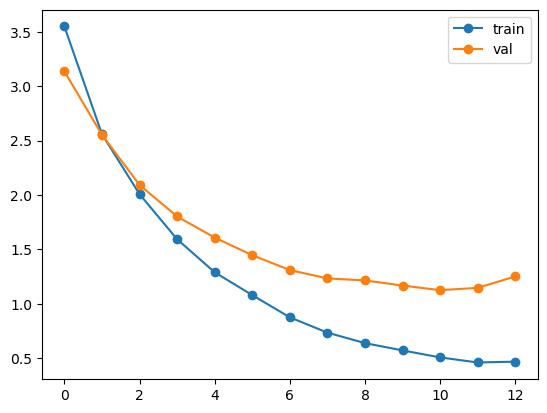

In [14]:
dense_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 128, activation = 'relu', kernel_regularizer = 'l2'),
    tf.keras.layers.Dense(units = num_outputs),
    tf.keras.layers.Reshape((1,-1))
])

history = compile_and_fit(dense_model, w1)

val_performance['Dense'] = dense_model.evaluate(w1.val)


plt.plot(history.history['loss'],'o-',label = 'train')
plt.plot(history.history['val_loss'],'o-', label = 'val')
plt.legend()

Epoch 1/20
22/22 [==============================] - 5s 112ms/step - loss: 3.3695 - mean_absolute_error: 0.7194 - val_loss: 2.5222 - val_mean_absolute_error: 0.7370
Epoch 2/20
22/22 [==============================] - 2s 89ms/step - loss: 1.8509 - mean_absolute_error: 0.6622 - val_loss: 1.6438 - val_mean_absolute_error: 0.7322
Epoch 3/20
22/22 [==============================] - 2s 83ms/step - loss: 1.2374 - mean_absolute_error: 0.6312 - val_loss: 1.4028 - val_mean_absolute_error: 0.7746
Epoch 4/20
22/22 [==============================] - 2s 91ms/step - loss: 0.9869 - mean_absolute_error: 0.6102 - val_loss: 1.1859 - val_mean_absolute_error: 0.7323
Epoch 5/20
22/22 [==============================] - 2s 90ms/step - loss: 0.8541 - mean_absolute_error: 0.5861 - val_loss: 1.1095 - val_mean_absolute_error: 0.7045
Epoch 6/20
22/22 [==============================] - 2s 100ms/step - loss: 0.7689 - mean_absolute_error: 0.5672 - val_loss: 1.1713 - val_mean_absolute_error: 0.7700
Epoch 7/20
22/22 [==

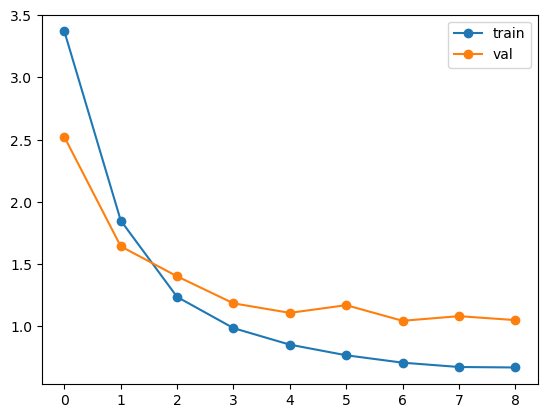

In [15]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, kernel_regularizer = 'l2'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation = 'relu', kernel_regularizer = 'l2'),
    tf.keras.layers.Dense(units=num_outputs),
    tf.keras.layers.Reshape((1,-1))
])

history = compile_and_fit(lstm_model, w1)

val_performance['LSTM'] = lstm_model.evaluate(w1.val)

plt.plot(history.history['loss'],'o-',label = 'train')
plt.plot(history.history['val_loss'],'o-', label = 'val')
plt.legend()

In [16]:
val_performance

{'Baseline': [1.8520762920379639, 1.0469719171524048],
 'Linear': [0.955303430557251, 0.7092961072921753],
 'Dense': [1.2525280714035034, 0.8262892961502075],
 'LSTM': [1.051357388496399, 0.7312036156654358]}

Perhaps surprisingly, the linear model does best. This could be due to the small size of the training set, which makes it difficult to train the deeper models.

Here, let's explicitly look at a output time series for the linear model.

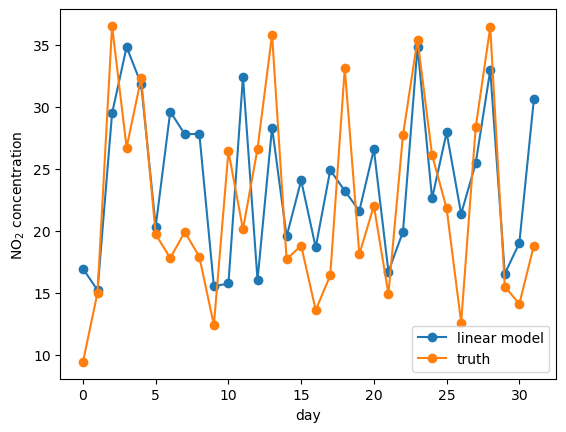

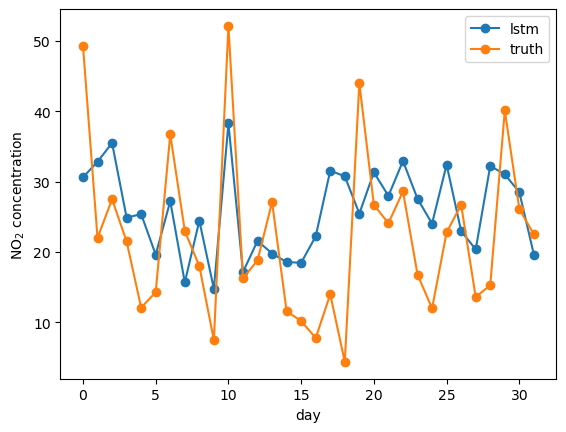

In [18]:
def rescale(x):
    return x * train_std[:-6] + train_mean[:-6]

for example_inputs, example_labels in w1.val.take(1):
    preds_linear = rescale(linear_model(example_inputs)[:,0,:])
    preds_lstm = rescale(lstm_model(example_inputs)[:,0,:])
    labels = rescale(example_labels[:,0,:])
    plt.plot(preds_linear[:,0],'o-', label = 'linear model')
    plt.plot(labels[:,0],'o-', label = 'truth')
plt.legend()
plt.xlabel('day')
plt.ylabel('NO$_2$ concentration')
plt.show()

for example_inputs, example_labels in w1.val.take(1):
    preds_linear = rescale(linear_model(example_inputs)[:,0,:])
    preds_lstm = rescale(lstm_model(example_inputs)[:,0,:])
    labels = rescale(example_labels[:,0,:])
    plt.plot(preds_lstm[:,0],'o-', label = 'lstm')
    plt.plot(labels[:,0],'o-', label = 'truth')
plt.legend()
plt.xlabel('day')
plt.ylabel('NO$_2$ concentration');